In [1]:
import time
start_time = time.time()

# 02_Modeling-UNet_vs_ResNet

## Setup and Imports

In [2]:
# =============================================================================
# SCRIPT: End-to-End Satellite Image Segmentation
# =============================================================================
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import glob
import os
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2025-07-25 07:34:09.248016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753428849.264330     990 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753428849.269096     990 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753428849.281881     990 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753428849.281905     990 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753428849.281908     990 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0
Num GPUs Available: 0


2025-07-25 07:34:12.133181: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Configuration & Constants

In [3]:
# --- File & Path Configuration ---
DATA_FOLDER = 'tfrecords/'
FILE_PATTERN = os.path.join(DATA_FOLDER, 'colombia_production_data-*.tfrecord.gz')

# --- Dataset & Image Constants ---
PATCH_SIZE = 256
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']
LABEL_BAND = 'label'
TCI_BANDS = ['B4', 'B3', 'B2']
NUM_BANDS = len(BANDS)
TCI_INDICES = [BANDS.index(b) for b in TCI_BANDS]

# --- Label & Visualization Constants ---
NUM_CLASSES = 9
CLASS_NAMES = [
    'Water', 'Trees', 'Grass', 'Flooded Veg', 'Crops',
    'Shrub/Scrub', 'Built Area', 'Bare Ground', 'Snow/Ice'
]
VIS_PALETTE = [
    '#419bdf', '#397d49', '#88b053', '#7a87c6', '#e49635',
    '#dfc35a', '#c4281b', '#a59b8f', '#b39fe1'
]

# --- Training Hyperparameters ---
BATCH_SIZE = 1
BUFFER_SIZE = 1000
EPOCHS = 3
VALIDATION_SPLIT = 0.1

In [4]:
def parse_tfrecord(example_proto):
    """Parses a single TFRecord example into image and one-hot label tensors."""
    feature_description = {band: tf.io.FixedLenFeature([PATCH_SIZE * PATCH_SIZE], tf.float32) for band in BANDS}
    feature_description[LABEL_BAND] = tf.io.FixedLenFeature([], tf.string)
    
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    features_list = [tf.reshape(example[band], [PATCH_SIZE, PATCH_SIZE]) for band in BANDS]
    image = tf.stack(features_list, axis=-1)
    
    label_decoded = tf.io.decode_raw(example[LABEL_BAND], tf.uint8)
    label = tf.reshape(label_decoded, [PATCH_SIZE, PATCH_SIZE])
    label_one_hot = tf.one_hot(tf.cast(label, tf.int32), depth=NUM_CLASSES)
    
    return image, label_one_hot

## Build and Split the Dataset

In [5]:
def build_dataset(file_pattern, batch_size, buffer_size, val_split):
    """
    Builds, splits, and batches the full dataset for training and validation.
    Also calculates and reports total dataset size metrics.
    """
    tfrecord_files = glob.glob(file_pattern)
    if not tfrecord_files:
        raise FileNotFoundError(f"No TFRecord files found matching pattern: {file_pattern}")
    print(f"Found {len(tfrecord_files)} TFRecord files.")

    # Create a raw dataset from all files
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type='GZIP')
    
    # --- Step 1: Count records and calculate size metrics ---
    print("Counting total records...")
    start_time = time.time()
    dataset_size = raw_dataset.reduce(np.int64(0), lambda x, _: x + 1).numpy()
    end_time = time.time()

    # --- NEW: Calculate total pixels and area ---
    total_pixels = dataset_size * (PATCH_SIZE ** 2)
    # Sentinel-2 resolution is 10 meters/pixel, so one pixel is 10m x 10m = 100 sq. meters
    sq_km_per_pixel = (10 * 10) / 1_000_000
    total_area_sq_km = total_pixels * sq_km_per_pixel

    print("\n==============================================")
    print("      DATASET SIZE REPORT")
    print("==============================================")
    print(f"Total number of {PATCH_SIZE}x{PATCH_SIZE} patches: {dataset_size:,}")
    print(f"Total number of pixels: {total_pixels:,}")
    print(f"Total unique area covered by patches: {total_area_sq_km:,.2f} km²")
    print(f"Record counting time: {end_time - start_time:.2f} seconds")
    print("==============================================\n")

    # --- Step 2: Build the full data pipeline ---
    # We now map and shuffle the raw_dataset that we already created
    dataset = raw_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size)
    
    # --- Step 3: Split into training and validation sets ---
    train_size = int((1 - val_split) * dataset_size)
    val_size = dataset_size - train_size

    # --- Step 3: Split into training and validation sets --- ONLY FOR TEST RUNS
    train_size = int(10)
    val_size = int(1)
    
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)
    
    print(f"Splitting into {train_size} training samples and {val_size} validation samples.")
    
    # --- Step 4: Apply batching and prefetching for performance ---
    train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    print("Data pipeline built and split successfully.")
    
    # Return the calculated sizes along with the datasets
    return train_dataset, validation_dataset, train_size, val_size

In [6]:
# Execution block:

train_dataset, validation_dataset, train_samples, val_samples = build_dataset(
    FILE_PATTERN, BATCH_SIZE, BUFFER_SIZE, VALIDATION_SPLIT
)

print(f"\nVerification: The script will train on {train_samples} samples and validate on {val_samples} samples.")

Found 2 TFRecord files.
Counting total records...


2025-07-25 07:34:12.387719: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144


## Initial Data Sanity Check (Visualization)


--- Displaying 3 truly random data samples for verification ---


2025-07-25 07:27:18.383827: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


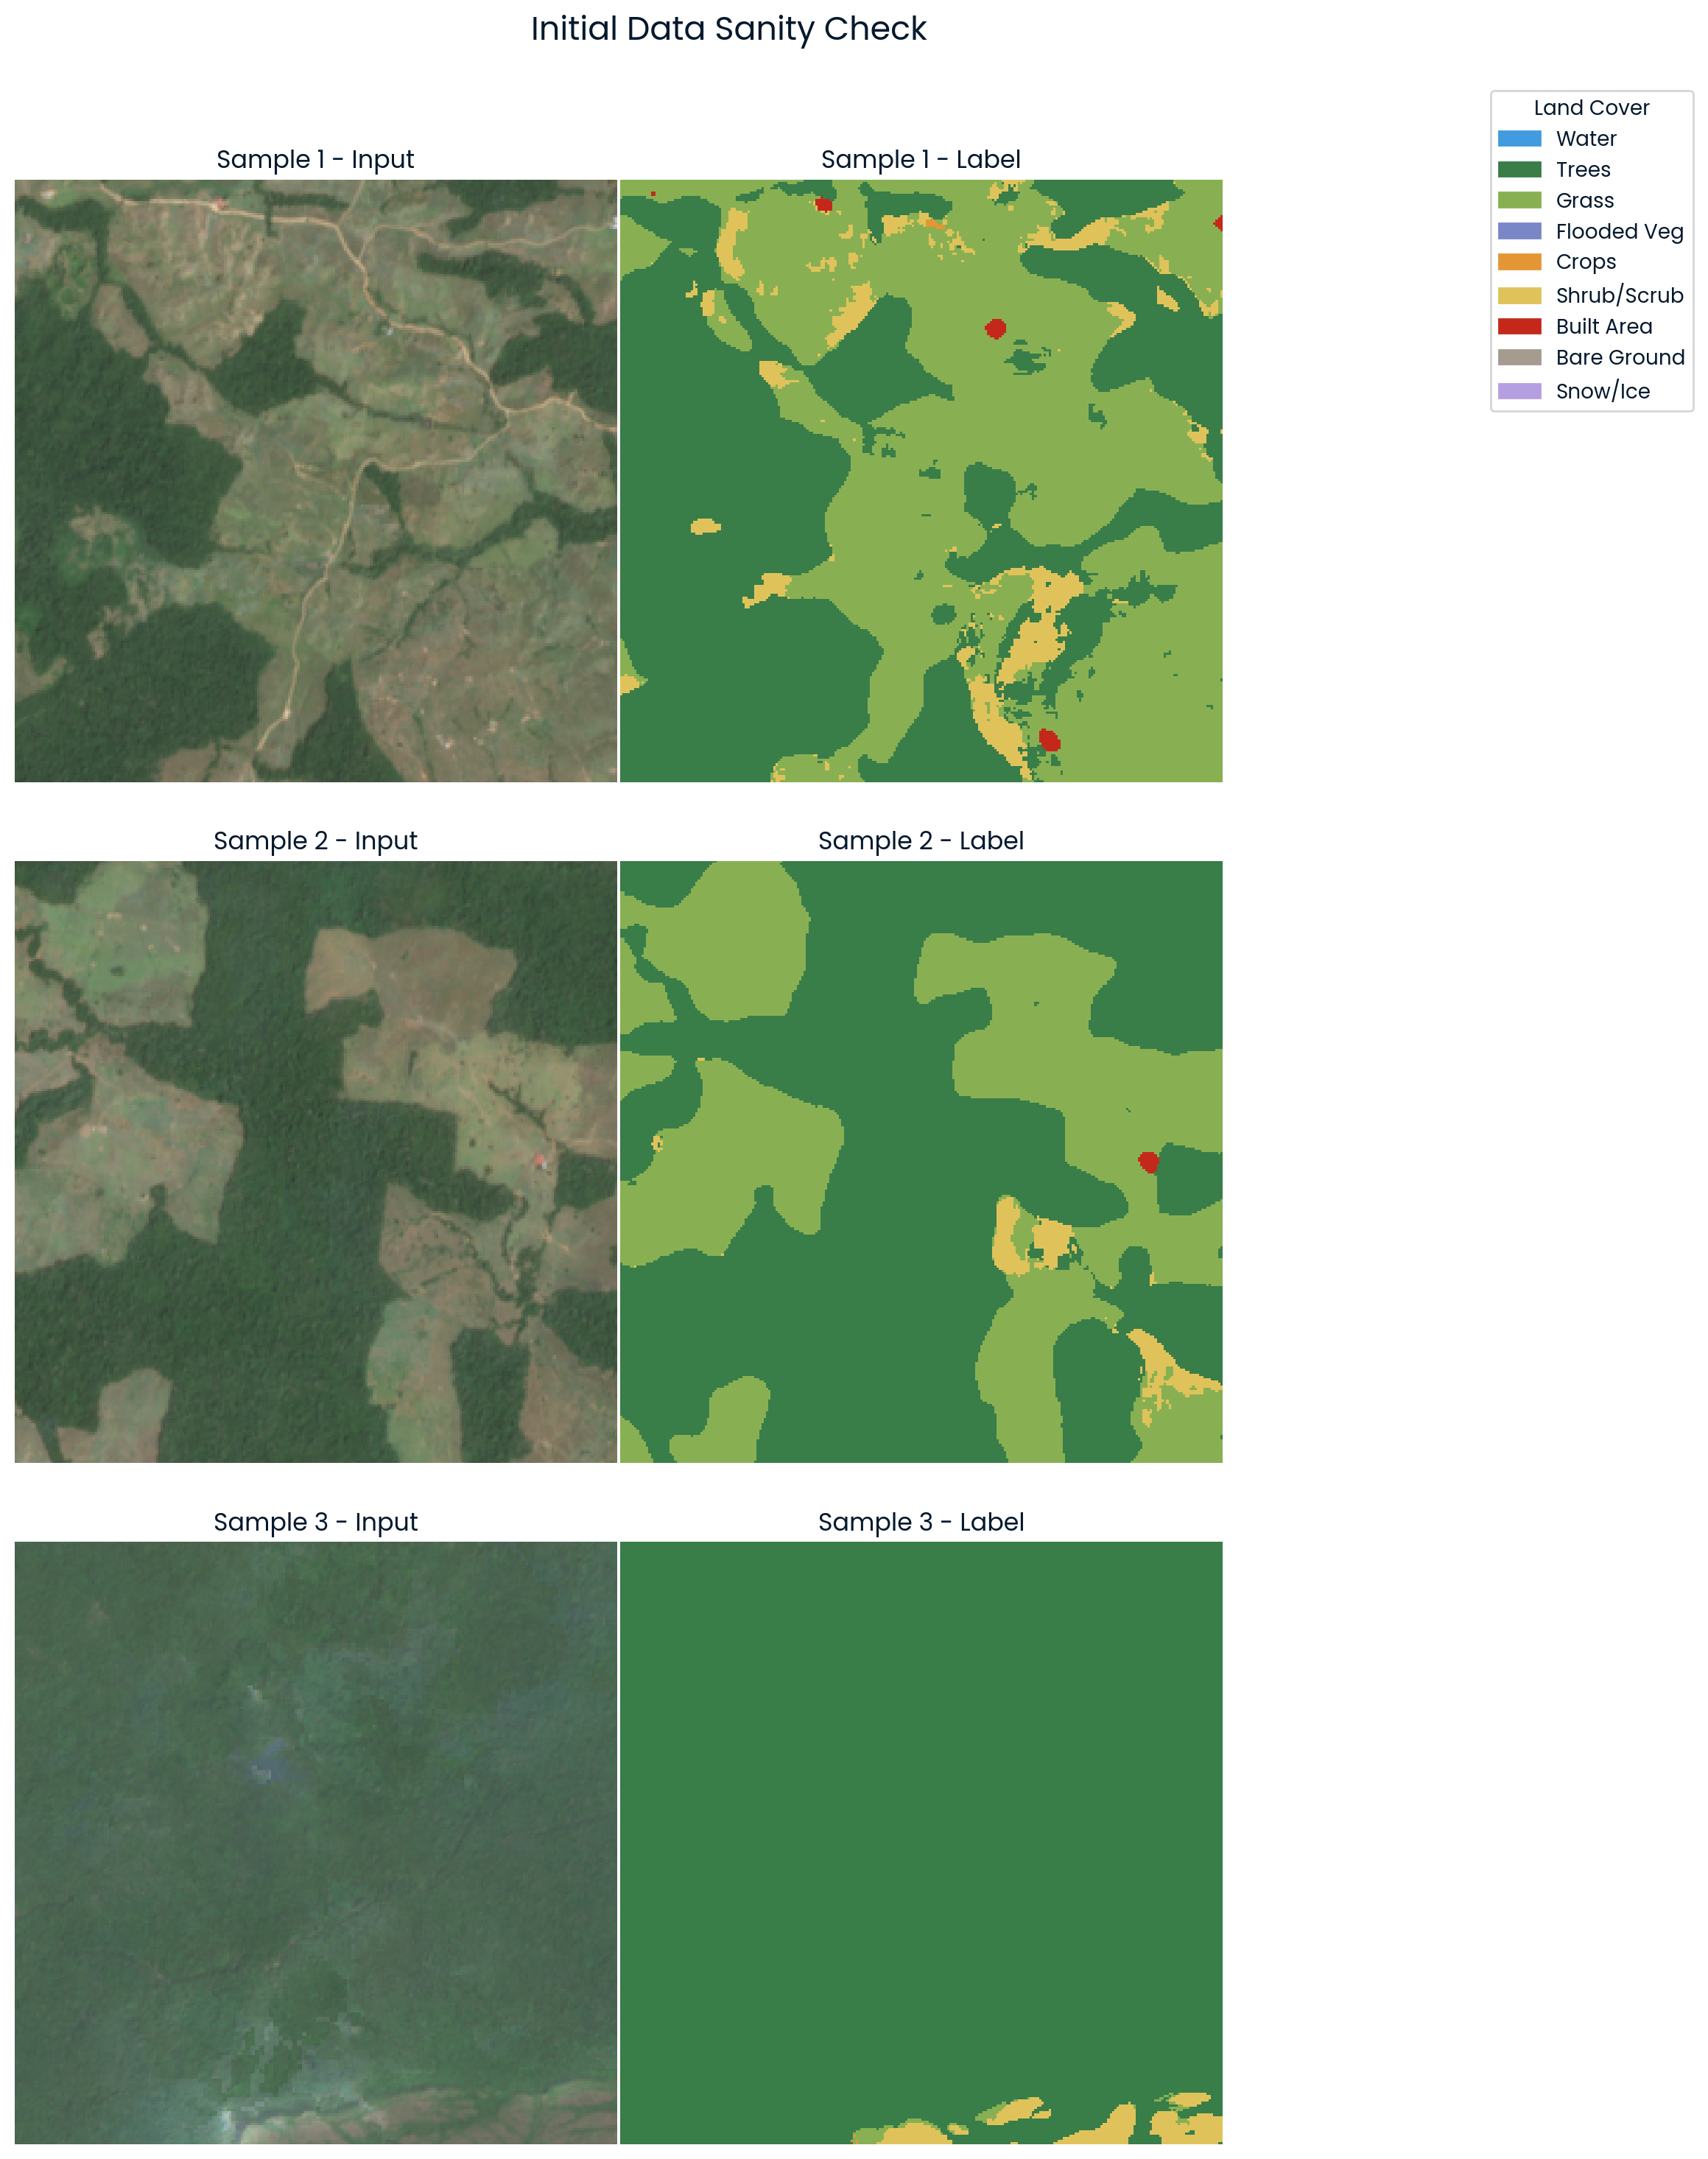

In [7]:
def visualize_data_samples(dataset, num_samples):
    """
    Visualizes a few TRULY random samples from a dataset to verify correctness.
    This function unbatches the data to ensure samples are not just from the same batch.
    """
    print(f"\n--- Displaying {num_samples} truly random data samples for verification ---")
    
    # Prepare colormap and normalization for plotting
    dw_colormap = ListedColormap(VIS_PALETTE)
    bounds = np.arange(-0.5, NUM_CLASSES, 1)
    dw_norm = BoundaryNorm(bounds, dw_colormap.N)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples), squeeze=False)
    fig.suptitle('Initial Data Sanity Check', fontsize=16)

    # --- KEY MODIFICATION START ---

    # 1. Unbatch the dataset to get a stream of individual samples.
    #    The dataset passed in is already shuffled, so taking the first N
    #    from the unbatched stream gives us N random individual samples.
    unbatched_dataset = dataset.unbatch()

    # 2. Take the desired number of random samples.
    #    .as_numpy_iterator() is convenient for looping.
    sample_iterator = unbatched_dataset.take(num_samples).as_numpy_iterator()

    # --- KEY MODIFICATION END ---

    # Loop through the individual samples and plot them
    for i, (image, label_one_hot) in enumerate(sample_iterator):
        # The label is one-hot encoded, convert it back to class indices
        label = np.argmax(label_one_hot, axis=-1)

        # Create True-Color Image for visualization
        tci_image = image[..., TCI_INDICES]
        # Apply gamma correction for better visual appeal
        tci_image = np.clip(tci_image, 0, 1) ** (1 / 1.8)
        
        # Plot Input Image
        axes[i, 0].imshow(tci_image)
        axes[i, 0].set_title(f'Sample {i+1} - Input')
        axes[i, 0].axis('off')

        # Plot Label Mask
        axes[i, 1].imshow(label, cmap=dw_colormap, norm=dw_norm)
        axes[i, 1].set_title(f'Sample {i+1} - Label')
        axes[i, 1].axis('off')

    # Create and add a single, shared legend for the entire figure
    patches = [Patch(color=VIS_PALETTE[i], label=CLASS_NAMES[i]) for i in range(NUM_CLASSES)]
    fig.legend(handles=patches, bbox_to_anchor=(1.01, 0.95), loc='upper left', title="Land Cover")
    plt.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to make room for legend
    plt.show()


visualize_data_samples(train_dataset, num_samples=3)

## Modelling

In [8]:
# =============================================================================
# --- 3. Model Definitions ---
# =============================================================================
def build_unet_model(input_shape=(PATCH_SIZE, PATCH_SIZE, NUM_BANDS), num_classes=NUM_CLASSES):
    """Builds a U-Net model with dropout for regularization."""
    # (Your proven U-Net code is placed here, unchanged)
    inputs = layers.Input(shape=input_shape)
    # ... [rest of U-Net code] ...
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    b = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    b = layers.Dropout(0.3)(b)
    b = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b)
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u6 = layers.concatenate([u6, c3])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c2])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c1])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c8)
    model = Model(inputs=[inputs], outputs=[outputs], name="U-Net")
    return model

# Add other model definitions here, e.g., build_resunet_model()
# ...

In [9]:
def compile_and_train(model, train_data, val_data, epochs):
    """Compiles, trains, and returns a model and its history."""
    model_name = model.name
    print(f"\n--- Starting Workflow for Model: {model_name} ---")
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy', tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=list(range(NUM_CLASSES)))])
    
    print(f"Model '{model_name}' compiled successfully.")
    model.summary()
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f'best_model_{model_name}.keras', save_best_only=True, monitor='val_loss', verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
    ]
    
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=callbacks
    )
    print(f"--- Finished Training: {model_name} ---")
    return history

In [10]:
# --- Main Training Loop ---
models_to_train = {
    "U-Net": build_unet_model(),
    # "ResU-Net": build_resunet_model(), # Uncomment to add more models
}

training_histories = {}
for name, model in models_to_train.items():
    history = compile_and_train(model, train_dataset, validation_dataset, epochs=EPOCHS)
    training_histories[name] = history


--- Starting Workflow for Model: U-Net ---
Model 'U-Net' compiled successfully.


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      2,624 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_7[0][0]  

 Total params: 1,927,593 (7.35 MB)

 Trainable params: 1,927,593 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
     10/Unknown 14s 339ms/step - accuracy: 0.6884 - loss: 1.4882 - one_hot_io_u: 0.0794

2025-07-25 07:27:33.411955: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: val_loss improved from inf to 0.87478, saving model to best_model_U-Net.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.6897 - loss: 1.4724 - one_hot_io_u: 0.0795 - val_accuracy: 0.8069 - val_loss: 0.8748 - val_one_hot_io_u: 0.0919
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8496 - loss: 0.6014 - one_hot_io_u: 0.1904

2025-07-25 07:28:40.809055: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_loss improved from 0.87478 to 0.51859, saving model to best_model_U-Net.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.8503 - loss: 0.5980 - one_hot_io_u: 0.1843 - val_accuracy: 0.8054 - val_loss: 0.5186 - val_one_hot_io_u: 0.0895
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7389 - loss: 0.6554 - one_hot_io_u: 0.0998
Epoch 3: val_loss improved from 0.51859 to 0.45915, saving model to best_model_U-Net.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.7466 - loss: 0.6404 - one_hot_io_u: 0.0995 - val_accuracy: 0.8063 - val_loss: 0.4591 - val_one_hot_io_u: 0.0896
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7378 - loss: 0.6315 - one_hot_io_u: 0.1066

2025-07-25 07:30:54.077398: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Error: Failed to execute this cell, please try again.

## Evaluation

In [11]:
def plot_training_histories(history_dict):
    """
    Plots the training and validation loss and IoU for all trained models
    on a single set of axes for direct comparison.
    """
    # Define line styles for clarity
    styles = ['-', '--', '-.', ':']
    
    num_metrics = 2
    plt.figure(figsize=(10 * num_metrics, 7))
    plt.suptitle('Model Performance Comparison', fontsize=16, y=1.02)

    # --- Plot 1: Loss Comparison ---
    ax1 = plt.subplot(1, num_metrics, 1)
    for i, (name, history) in enumerate(history_dict.items()):
        style = styles[i % len(styles)]
        # Plot Training Loss
        ax1.plot(history.history['loss'], 
                 label=f'{name} Train Loss', 
                 linestyle=style, 
                 color=plt.cm.viridis(i / len(history_dict)))
        # Plot Validation Loss
        ax1.plot(history.history['val_loss'], 
                 label=f'{name} Val Loss', 
                 linestyle=style, 
                 color=plt.cm.plasma(i / len(history_dict)))
        
    ax1.set_title('Training & Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Plot 2: IoU Comparison ---
    ax2 = plt.subplot(1, num_metrics, 2)
    for i, (name, history) in enumerate(history_dict.items()):
        style = styles[i % len(styles)]
        
        # Dynamically find the IoU metric names
        train_iou_key = next((key for key in history.history if 'one_hot_io_u' in key and not 'val_' in key), None)
        val_iou_key = next((key for key in history.history if 'val_one_hot_io_u' in key), None)
        
        if train_iou_key and val_iou_key:
            # Plot Training IoU
            ax2.plot(history.history[train_iou_key], 
                     label=f'{name} Train IoU', 
                     linestyle=style, 
                     color=plt.cm.viridis(i / len(history_dict)))
            # Plot Validation IoU
            ax2.plot(history.history[val_iou_key], 
                     label=f'{name} Val IoU', 
                     linestyle=style, 
                     color=plt.cm.plasma(i / len(history_dict)))

    ax2.set_title('Training & Validation Mean IoU', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean IoU')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

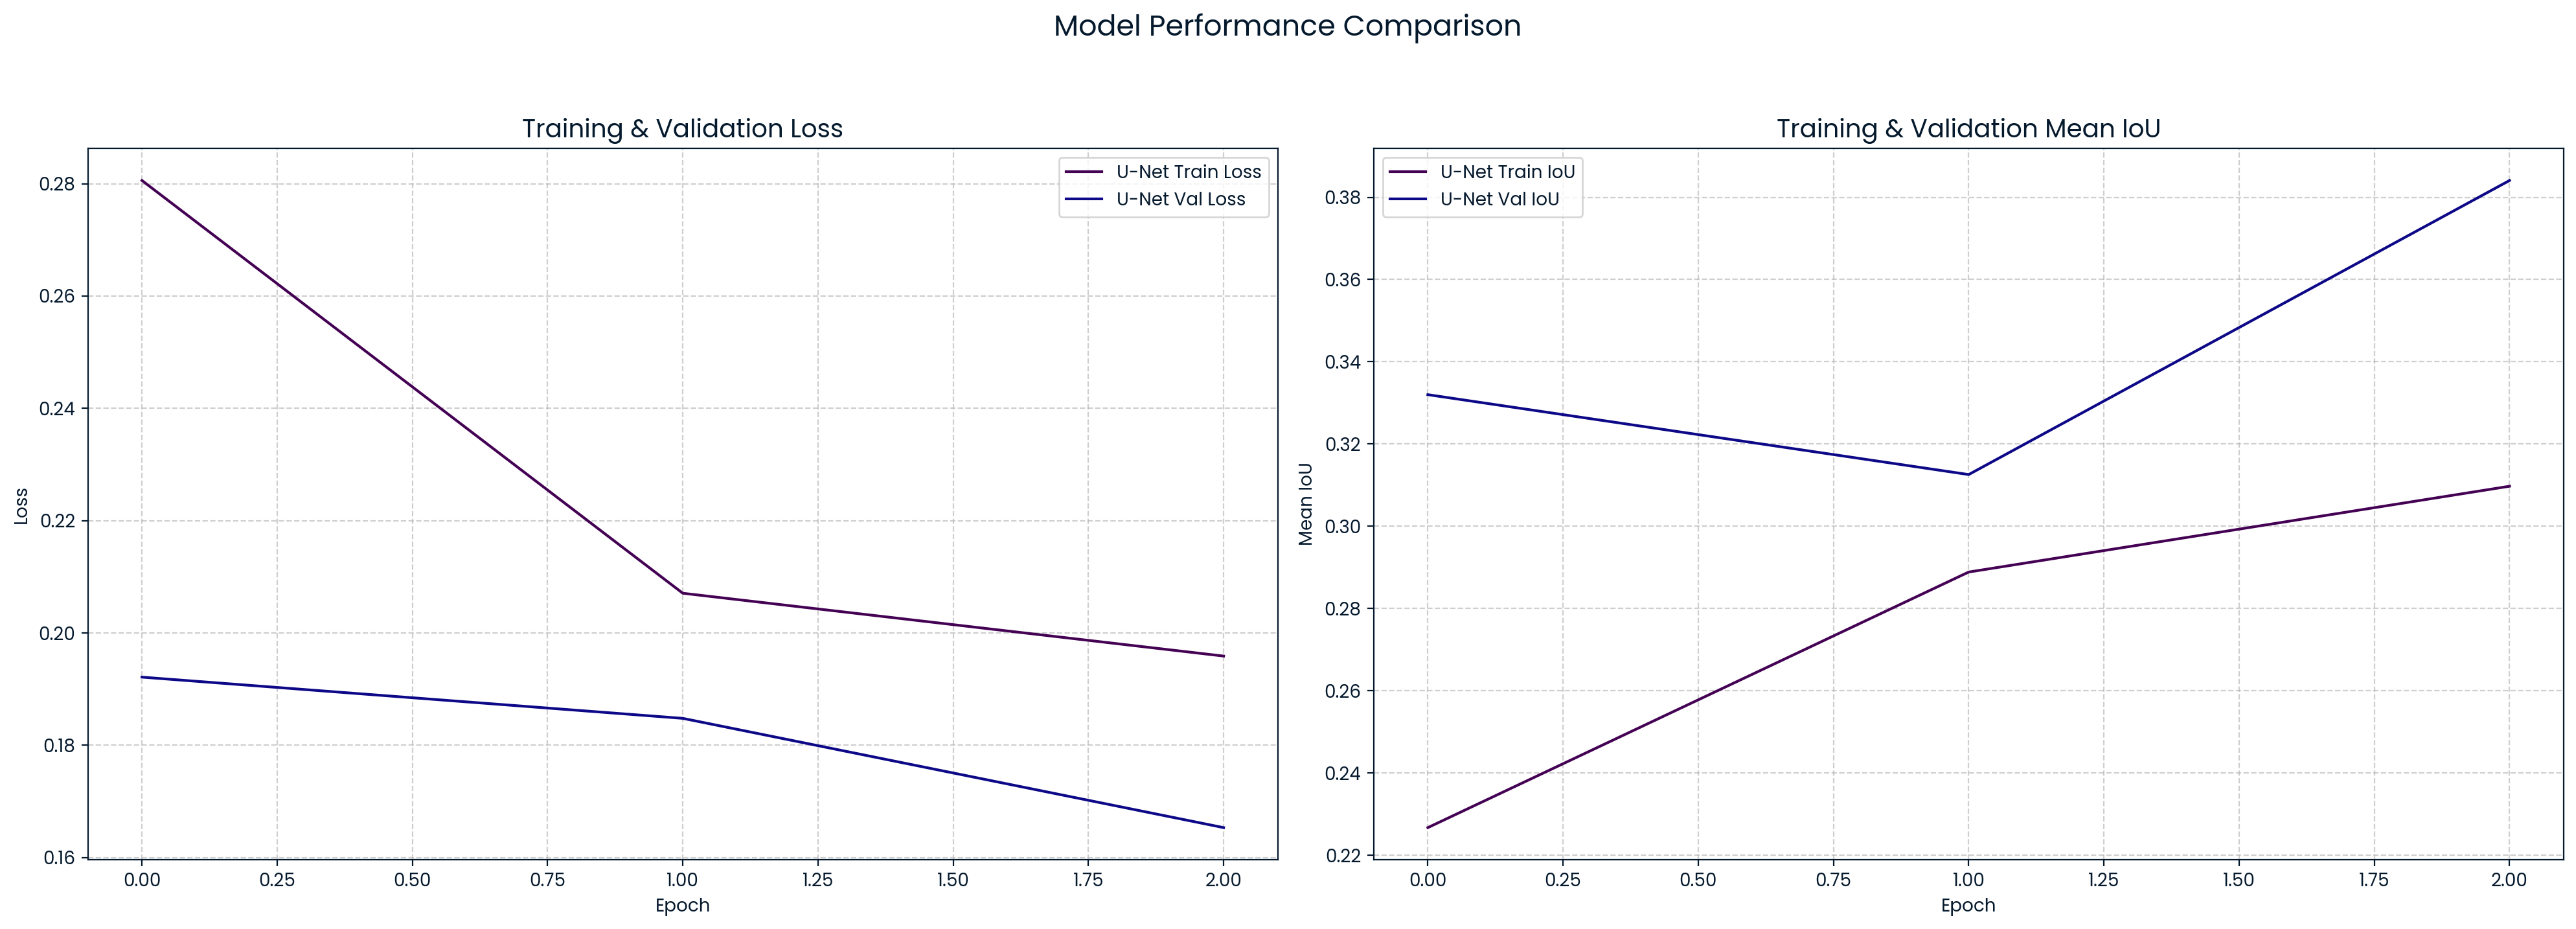

In [12]:
# Execution
if training_histories:
    plot_training_histories(training_histories)
else:
    print("No models were trained. Skipping history plot.")

In [13]:
# Add seaborn to your imports if you haven't already
import seaborn as sns 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_and_report_metrics(models_dict, validation_dataset):
    """
    Evaluates trained models on the entire validation dataset, prints a
    classification report, and plots a confusion matrix.
    """
    print("\n" + "="*50)
    print("--- GENERATING FINAL EVALUATION METRICS ---")
    print("="*50)
    print("Iterating through the entire validation set to get all predictions...")
    
    # --- Step 1: Get all true labels and predictions ---
    all_true_labels = []
    all_pred_labels_dict = {name: [] for name in models_dict.keys()}
    
    for image_batch, label_batch in validation_dataset:
        true_labels = np.argmax(label_batch.numpy(), axis=-1).flatten()
        all_true_labels.extend(true_labels)
        
        for name, model in models_dict.items():
            pred_batch = model.predict(image_batch)
            pred_labels = np.argmax(pred_batch, axis=-1).flatten()
            all_pred_labels_dict[name].extend(pred_labels)
            
    print("Finished collecting all labels and predictions.")

    # --- Step 2: For each model, calculate and display metrics ---
    
    # --- THIS IS THE KEY ---
    # Define the full set of expected labels (0 through 8)
    expected_labels = np.arange(NUM_CLASSES)

    for name, pred_labels in all_pred_labels_dict.items():
        print("\n" + "-"*20 + f" REPORT FOR MODEL: {name} " + "-"*20)
        
        # --- a) Classification Report (Precision, Recall, F1-Score) ---
        # Add the 'labels' parameter to ensure all 9 classes are in the report
        report = classification_report(
            all_true_labels, 
            pred_labels, 
            target_names=CLASS_NAMES, 
            labels=expected_labels,  # <--- FIX IS HERE
            zero_division=0
        )
        print("\nClassification Report:")
        print(report)
        
        # --- b) Overall Accuracy ---
        accuracy = accuracy_score(all_true_labels, pred_labels)
        print(f"Overall Pixel Accuracy: {accuracy:.4f}")
        
        # --- c) Confusion Matrix ---
        # The 'labels' parameter was already here, which is great practice!
        cm = confusion_matrix(all_true_labels, pred_labels, labels=expected_labels)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title(f'Confusion Matrix - {name}', fontsize=16)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()


--- GENERATING FINAL EVALUATION METRICS ---
Iterating through the entire validation set to get all predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━

2025-07-24 15:17:22.126223: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report:
              precision    recall  f1-score   support

       Water       0.85      0.89      0.87     36569
       Trees       0.94      0.99      0.96   4579056
       Grass       0.85      0.72      0.78   1032348
 Flooded Veg       0.00      0.00      0.00       374
       Crops       0.00      0.00      0.00       819
 Shrub/Scrub       0.58      0.30      0.40    176493
  Built Area       0.71      0.00      0.00      5446
 Bare Ground       0.68      0.72      0.70      1595
    Snow/Ice       0.00      0.00      0.00         4

    accuracy                           0.92   5832704
   macro avg       0.51      0.40      0.41   5832704
weighted avg       0.91      0.92      0.91   5832704

Overall Pixel Accuracy: 0.9172


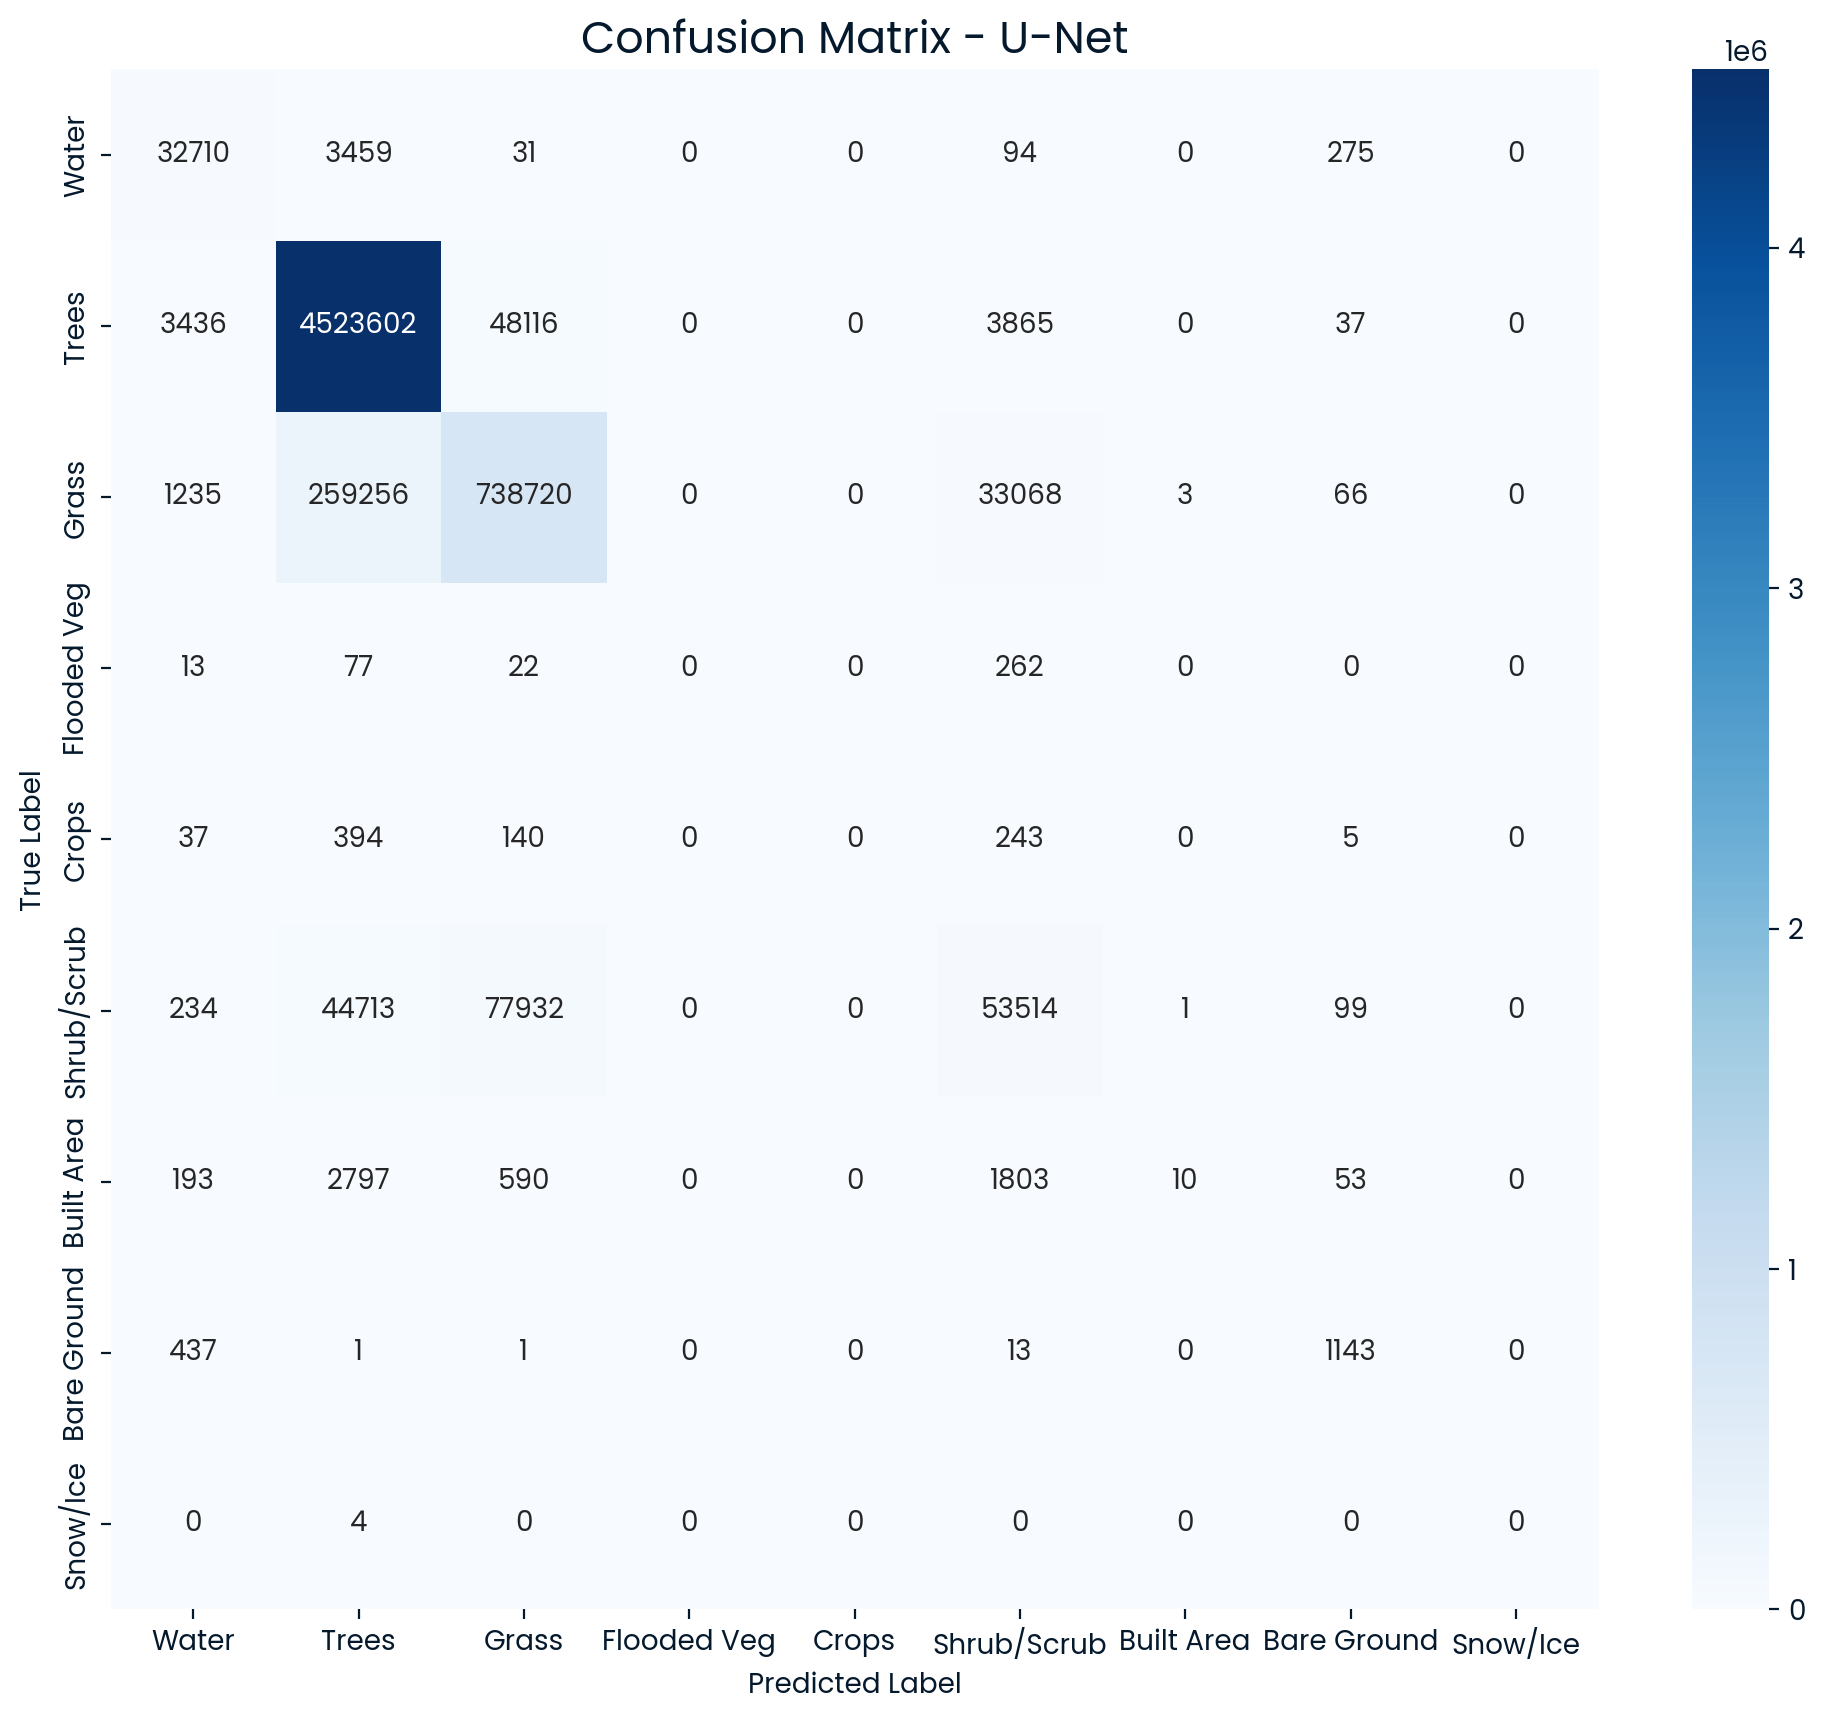

In [14]:
# In your `if __name__ == "__main__":` block at the end:

# Load the best versions of the trained models for final visualization
best_trained_models = {
    name: tf.keras.models.load_model(f'best_model_{name}.keras') 
    for name in models_to_train.keys()
}

# --- NEW: Call the final quantitative evaluation ---
if best_trained_models:
    evaluate_and_report_metrics(best_trained_models, validation_dataset)

## Final Prediction Visualization

Loading best model for 'U-Net' from best_model_U-Net.keras

--- Generating Final Prediction Visualizations ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


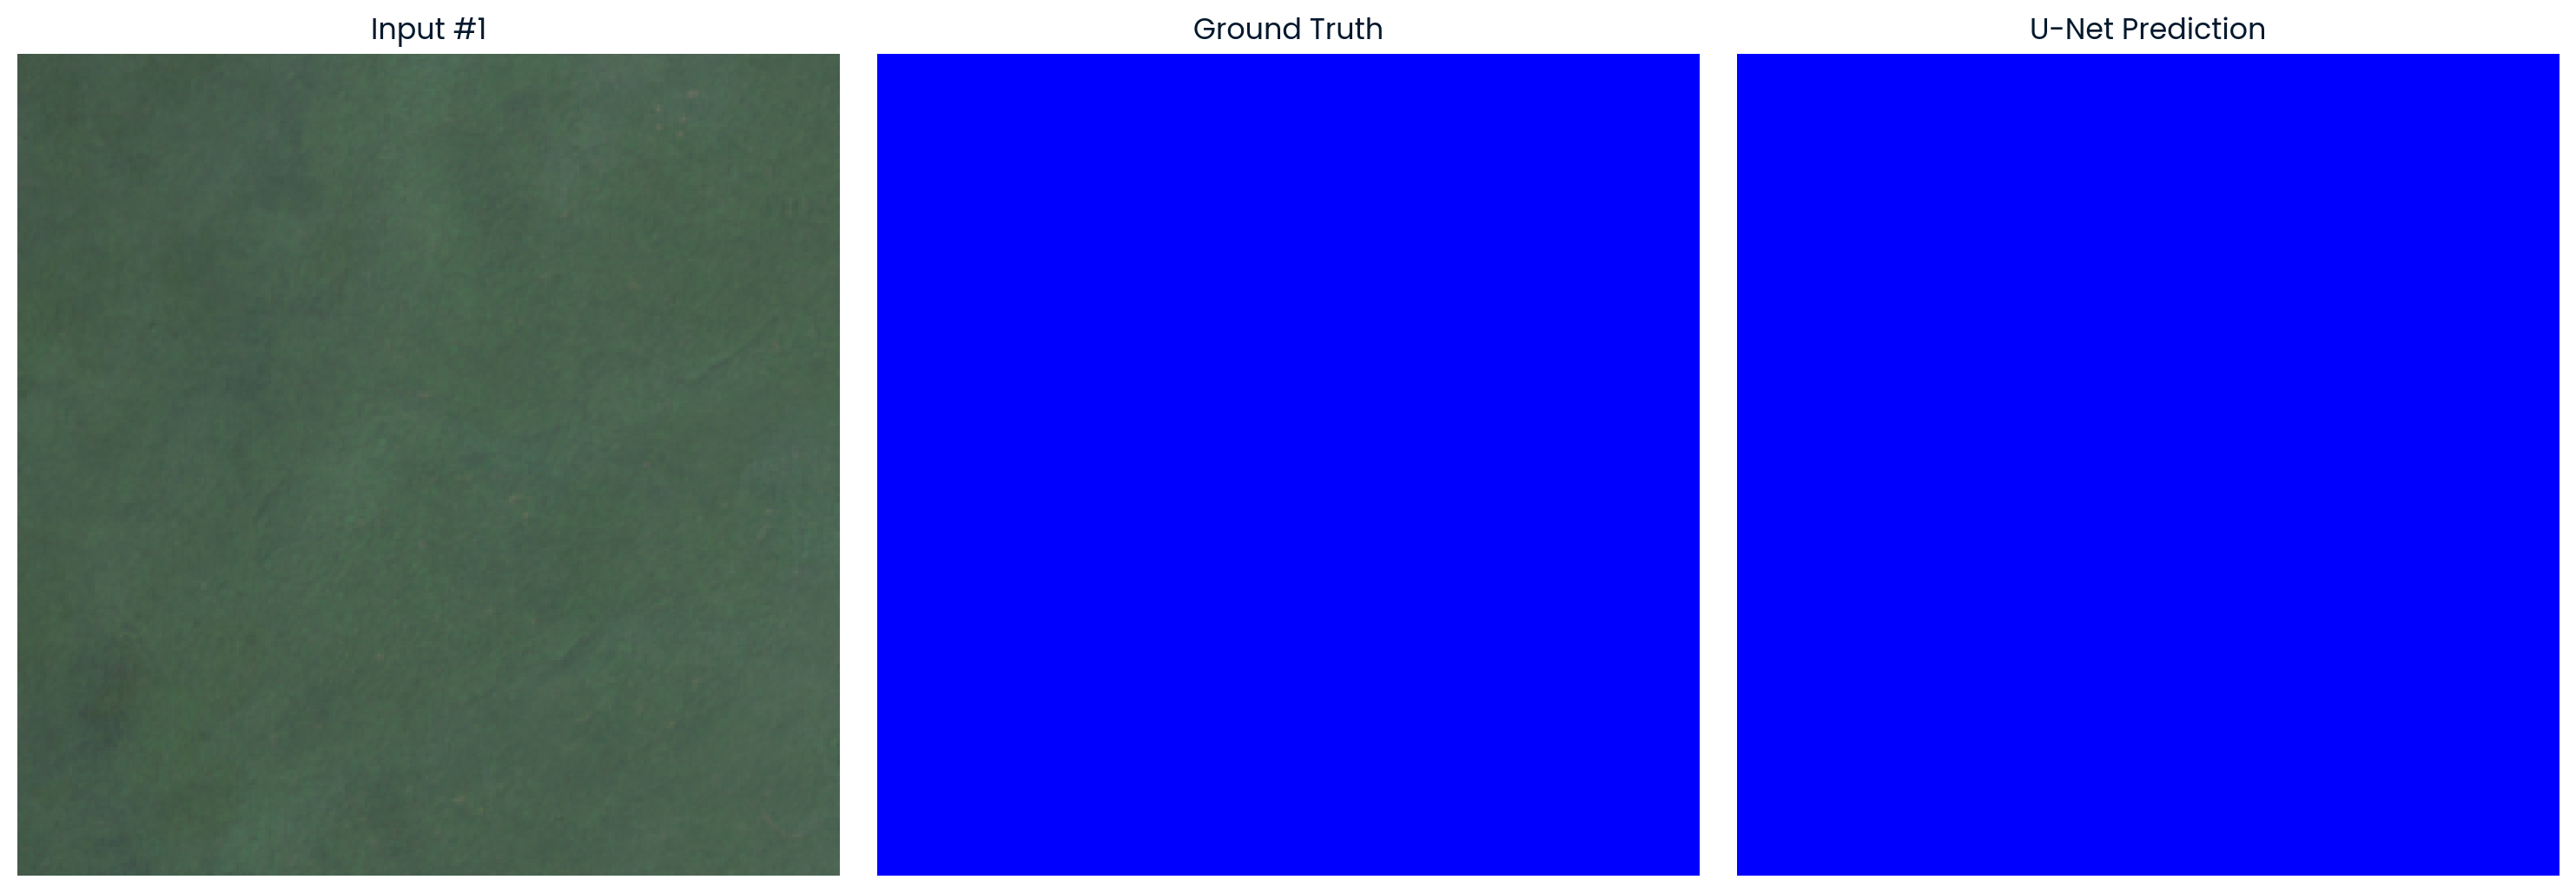

In [15]:
def visualize_predictions(models_dict, val_data, num_samples=3):
    """Visualizes model predictions against ground truth."""
    print("\n--- Generating Final Prediction Visualizations ---")
    
    if not models_dict:
        print("No models to visualize.")
        return

    image_batch, label_batch = next(iter(val_data))
    true_labels = np.argmax(label_batch.numpy(), axis=-1)

    predictions = {name: np.argmax(model.predict(image_batch), axis=-1) for name, model in models_dict.items()}
    
    num_models = len(models_dict)
    fig_cols = 2 + num_models
    
    plt.figure(figsize=(5 * fig_cols, 5 * num_samples))
    for i in range(min(num_samples, image_batch.shape[0])):
        ax_img = plt.subplot(num_samples, fig_cols, i * fig_cols + 1)
        tci_image = image_batch.numpy()[i][..., TCI_INDICES]
        tci_image = np.clip(tci_image, 0, 1) ** (1 / 1.8)
        ax_img.imshow(tci_image); ax_img.set_title(f"Input #{i+1}"); ax_img.axis('off')

        ax_gt = plt.subplot(num_samples, fig_cols, i * fig_cols + 2)
        ax_gt.imshow(true_labels[i], cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
        ax_gt.set_title("Ground Truth"); ax_gt.axis('off')
        
        for j, (name, pred_labels) in enumerate(predictions.items()):
            ax_pred = plt.subplot(num_samples, fig_cols, i * fig_cols + 3 + j)
            ax_pred.imshow(pred_labels[i], cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
            ax_pred.set_title(f"{name} Prediction"); ax_pred.axis('off')

    plt.tight_layout()
    plt.show()

# Load best models and visualize
best_trained_models = {}
for name in models_to_train.keys():
    model_path = f'best_model_{name}.keras'
    if os.path.exists(model_path):
        print(f"Loading best model for '{name}' from {model_path}")
        best_trained_models[name] = tf.keras.models.load_model(model_path)
    else:
        print(f"Could not find saved model for '{name}'. Skipping visualization.")

if best_trained_models:
    visualize_predictions(best_trained_models, validation_dataset, num_samples=3)

In [16]:
# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes and seconds
minutes, seconds = divmod(elapsed_time, 60)

# Display the elapsed time in minutes and seconds
f"Total Run Time: {int(minutes)} minutes and {seconds:.2f} seconds"

'Total Run Time: 15 minutes and 21.73 seconds'

In [17]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
import time

# =============================================================================
# --- 1. Define the Logging Function ---
# =============================================================================

def log_experiment(log_file_path, run_data):
    """
    Appends the results of a completed run to a CSV log file.
    Creates the file with a header if it doesn't exist.
    """
    # Create the DataFrame for the new log entry
    new_log_df = pd.DataFrame([run_data])
    
    # Check if the file exists to determine if we need to write a header
    write_header = not os.path.exists(log_file_path)
    
    # Append to the CSV file
    new_log_df.to_csv(log_file_path, mode='a', header=write_header, index=False)
    
    print("\n" + "="*50)
    print(f"SUCCESS: Run results have been logged to '{log_file_path}'")
    print("="*50)

# =============================================================================
# --- 2. Collect Data from the Run ---
# =============================================================================
# This block assumes your script has already run and these variables exist:
# - training_histories: A dictionary mapping model names to their history objects.
# - train_samples, val_samples: The number of patches in each dataset split.
# - BATCH_SIZE, EPOCHS: The hyperparameters used.

print("\n--- Collecting final results for logging ---")

# --- Initialize a dictionary to hold all results ---
final_run_data = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'models_trained': ", ".join(training_histories.keys()),
    'training_samples': train_samples,
    'validation_samples': val_samples,
    'batch_size': BATCH_SIZE,
    'epochs_run': None, # We'll populate this per model
    'best_val_loss': None,
    'best_val_iou': None,
    'best_model_name': None,
    'notes': "U-Net vs ResU-Net comparison run." # <-- IMPORTANT: Manually change this note for each run
}

# --- Find the best overall model from this run based on validation loss ---
best_loss = float('inf')
best_model_name = None

for name, history in training_histories.items():
    # Find the epoch with the lowest validation loss for this model
    best_epoch_idx = np.argmin(history.history['val_loss'])
    current_loss = history.history['val_loss'][best_epoch_idx]
    
    # Check if this model is the best one so far
    if current_loss < best_loss:
        best_loss = current_loss
        best_model_name = name
        
        # Capture the results from the best model
        final_run_data['epochs_run'] = len(history.history['loss'])
        final_run_data['best_val_loss'] = best_loss
        
        # Find the corresponding validation IoU at that best epoch
        iou_key = next((key for key in history.history if 'val_one_hot_io_u' in key), None)
        if iou_key:
            final_run_data['best_val_iou'] = history.history[iou_key][best_epoch_idx]

final_run_data['best_model_name'] = best_model_name


# =============================================================================
# --- 3. Execute the Logging ---
# =============================================================================

LOG_FILE = 'experiment_log.csv'
log_experiment(LOG_FILE, final_run_data)

# --- Display the new log entry and the full log file for confirmation ---
print("\n--- Newly Added Log Entry ---")
display(pd.DataFrame([final_run_data]))

print("\n--- Full Experiment Log ---")
display(pd.read_csv(LOG_FILE))


--- Collecting final results for logging ---

SUCCESS: Run results have been logged to 'experiment_log.csv'

--- Newly Added Log Entry ---


,timestamp,models_trained,training_samples,validation_samples,batch_size,epochs_run,best_val_loss,best_val_iou,best_model_name,notes
0,2025-07-24 15:17:39,U-Net,795,89,1,3,0.165344,0.384084,U-Net,U-Net vs ResU-Net comparison run.



--- Full Experiment Log ---


,timestamp,models_trained,training_samples,validation_samples,batch_size,epochs_run,best_val_loss,best_val_iou,best_model_name,notes
0,2025-07-24 09:03:02,U-Net,397,45,1,3,0.279427,0.354679,U-Net,U-Net vs ResU-Net comparison run.
1,2025-07-24 09:10:07,U-Net,397,45,1,3,0.279427,0.354679,U-Net,U-Net vs ResU-Net comparison run.
2,2025-07-24 15:17:39,U-Net,795,89,1,3,0.165344,0.384084,U-Net,U-Net vs ResU-Net comparison run.
